In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download aiunict-2023
!unzip aiunict-2023

100% 431M/431M [00:29<00:00, 17.0MB/s]
100% 431M/431M [00:29<00:00, 15.3MB/s]
Archive:  aiunict-2023.zip
  inflating: submission.csv          
  inflating: test.csv                
  inflating: test/000.jpg            
  inflating: test/001.jpg            
  inflating: test/002.jpg            
  inflating: test/003.jpg            
  inflating: test/004.jpg            
  inflating: test/005.jpg            
  inflating: test/006.jpg            
  inflating: test/007.jpg            
  inflating: test/008.jpg            
  inflating: test/009.jpg            
  inflating: test/010.jpg            
  inflating: test/011.jpg            
  inflating: test/012.jpg            
  inflating: test/013.jpg            
  inflating: test/014.jpg            
  inflating: test/015.jpg            
  inflating: test/016.jpg            
  inflating: test/017.jpg            
  inflating: test/018.jpg            
  inflating: test/019.jpg            
  inflating: test/020.jpg            
  inflating: test/021

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
dest_dir = ""
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importing Libraries

In [4]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
#from engine import train_one_epoch, evaluate
#import utils
#import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from numpy import asarray


In [5]:
class Datasetimage(Dataset):
    def __init__(self, dset_dir, train=True,mask=False, transforms=None):
        self.split = "train" if train else "test"
        self.dset_dir = Path(dset_dir)/self.split
        self.transforms = transforms
        self.files = []
        
        

        self.mask=mask
        self.df_mask=pd.DataFrame()
        folders = sorted(os.listdir(self.dset_dir))
        
        if self.split=="train" :
            if  mask:
                self.df_mask=pd.read_csv(dest_dir+"train.csv")
            for folder in folders:
                class_idx= folders.index(folder)
                folder_dir = self.dset_dir/folder
                files = os.listdir(folder_dir)
                if(class_idx==0):
                    for x in files:
                        self.files.append({"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False})
                else:
                    for x in files:
                        self.files.append({"mask":folder+"/"+x,"file": folder_dir/x, "class": class_idx+1,"flag":False})
        else:
            self.file=folders
            for file in folders:
                 self.files.append(self.dset_dir/file)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        
        if self.split == "train":
            item = self.files[i]
            file = item['file']
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            # recover bounding boxes
            name_file_img=item['mask']
            mask_data=self.df_mask[self.df_mask["image"]==name_file_img]
            xmin=int(mask_data["x1"])+1
            ymin=int(mask_data["y1"])+1
            xmax=int(mask_data["x2"])-1
            ymax=int(mask_data["y2"])-1
            
            # resize bounding boxes
            boxes = []           
            boxes.append([xmin, ymin, xmax, ymax])
            # convert boxes into a torch.Tensor
            boxes = torch.as_tensor(boxes, dtype=torch.int64)            
            labels = torch.tensor(item['class'],dtype=torch.int64)
            labels=labels.unsqueeze(0)
            
            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
                        
            if self.transforms:
            
                sample = {'image' : img_res,
                          'bboxes' : target['boxes'],
                          'labels' : labels
                         }
               
                sample = self.transforms(**sample)
                img_res = sample['image']
                target['boxes'] = torch.as_tensor((sample['bboxes']),dtype=torch.int64)
                
               
            return img_res, target
        else:
            file = self.files[i]
            # reading the images and converting them to correct size and color    
            img = cv2.imread(str(file))
            img_res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
            # diving by 255
            img_res /= 255.0
            
            if self.transforms:
                sample = {
                    'image': img_res,
                }
                sample = self.transforms(**sample)
                image = sample['image']
                
                #image=image.permute(1,2,0)
            return image,self.file[i]
        

    



In [6]:
# Albumentations
def get_train_transform():
    return A.Compose([
        
        A.Flip(0.5),
        A.ShiftScaleRotate(shift_limit=0.2,scale_limit=0.25, rotate_limit=45, p=0.7),        
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_test_transform():
    return A.Compose([
        A.Normalize(mean=(0.7, 0.7, 0.7), std=(1, 1, 1), max_pixel_value=255.0, p=1.0),
        ToTensorV2(p=1.0)
    ])

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = Datasetimage(dest_dir, train=True,mask=True, transforms= get_train_transform())

train_data_loader = DataLoader(
    dataset,
    batch_size=8,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)
dataset.__len__()

1600

In [8]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target=None,train=True):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    if(train):
        fig, a = plt.subplots(1,1)
        fig.set_size_inches(4,4)
        a.imshow(img)
        for box in (target['boxes'].cpu()):
            x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
            rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 3,
                                 edgecolor = 'r',
                                 facecolor = 'none')

            # Draw the bounding box on top of the image
            a.add_patch(rect)
        plt.show()
    else:
        fig, a = plt.subplots(1,1)
        fig.set_size_inches(4,4)
        a.imshow(img)
        plt.show()
    #print(target['labels'])
    #print(target['boxes'])
    
# plotting the image with bboxes. Feel free to change the index
# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

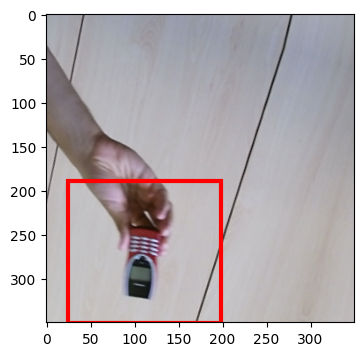

In [10]:
img, target = dataset[270]
img=torch_to_pil(img)
plot_img_bbox(img, target)

In [11]:

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 9 # 8 Classes + 1 background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 159MB/s]


In [12]:
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [13]:


def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction


In [14]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0001)
lr_scheduler =None# torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)



In [16]:
num_epochs =  8 #Low epoch to save GPU time
loss_hist = Averager()
itr = 1
lossHistoryiter = []
lossHistoryepoch = []
true_lab=[]
import time
start = time.time()

for epoch in range(num_epochs):
    loss_hist.reset()
    model.train()
    for images, targets in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)  
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        loss_hist.send(loss_value)
        lossHistoryiter.append(loss_value)
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    #if lr_scheduler is not None:
        #lr_scheduler.step()
    lossHistoryepoch.append(loss_hist.value)
    print(f"Epoch #{epoch} loss: {loss_hist.value}")
    
    #evaluation
    
    
end = time.time()
hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Time taken to Train the model :{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
                                                              

Iteration #50 loss: 0.3588090240955353
Iteration #100 loss: 0.3069908022880554
Iteration #150 loss: 0.27467960119247437
Iteration #200 loss: 0.29948320984840393
Epoch #0 loss: 0.3733948804438114
Iteration #250 loss: 0.267709344625473
Iteration #300 loss: 0.25426626205444336
Iteration #350 loss: 0.25360435247421265
Iteration #400 loss: 0.22328448295593262
Epoch #1 loss: 0.27452994115650653
Iteration #450 loss: 0.25070416927337646
Iteration #500 loss: 0.236802339553833
Iteration #550 loss: 0.17437607049942017
Iteration #600 loss: 0.16033580899238586
Epoch #2 loss: 0.21441540740430354
Iteration #650 loss: 0.15994469821453094
Iteration #700 loss: 0.14396341145038605
Iteration #750 loss: 0.17938745021820068
Iteration #800 loss: 0.1841917783021927
Epoch #3 loss: 0.1749928365647793
Iteration #850 loss: 0.161178320646286
Iteration #900 loss: 0.18463760614395142
Iteration #950 loss: 0.17510616779327393
Iteration #1000 loss: 0.1174590140581131
Epoch #4 loss: 0.16282826576381923
Iteration #1050 l

# Testing model with Test Data

In [17]:
test_dataset = Datasetimage(dest_dir, train=False, transforms= get_test_transform())

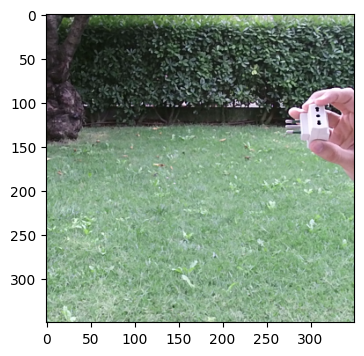

predicted #boxes:  {'boxes': tensor([[237.1005,  56.9444, 350.0000, 186.9494]], device='cuda:0'), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9706], device='cuda:0')}
EXPECTED OUTPUT


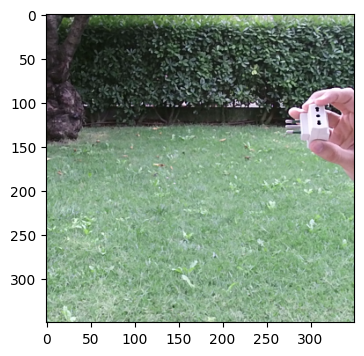

MODEL OUTPUT


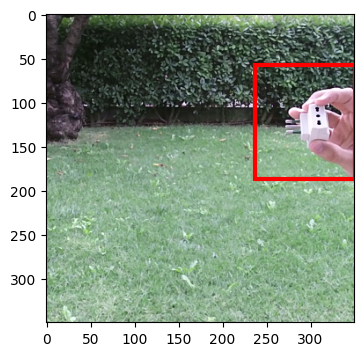

tensor([1], device='cuda:0')
NMS APPLIED MODEL OUTPUT


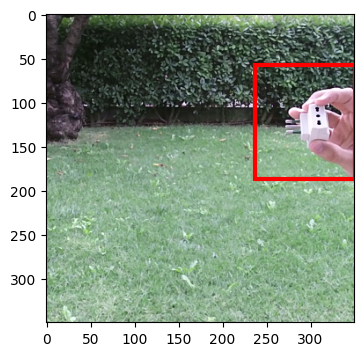

1


In [18]:
img,name_file = test_dataset[4]
plot_img_bbox(torch_to_pil(img), train=False)


# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', prediction)


print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), train=False)
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)
print(prediction['labels'])
nms_prediction = apply_nms(prediction, iou_thresh=0.2)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)
print(nms_prediction['labels'].cpu().numpy()[0])

In [19]:

ls_image=[]
ls_class=[]
for idx in range(test_dataset.__len__()):
    img,name_file = test_dataset[idx]

    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    nms_prediction = apply_nms(prediction, iou_thresh=0.2)
    pred=nms_prediction['labels'].cpu().numpy()[0]
    
    ls_image.append(name_file)
    ls_class.append(pred-1)
    #print("file: "+str(file)+" preds: "+str(preds))
    
import pandas as pd

d = {'image': ls_image, 'class': ls_class}
df = pd.DataFrame(data=d)

In [20]:
import plotly.graph_objects as go

x = [i for i in range(num_epochs)]
y = lossHistoryepoch
fig = go.Figure()
fig.add_trace(go.Scatter(x=x,y=y,
                    mode='lines',
                    name='lines'))

fig.update_layout(title='Loss vs Epochs',
                   xaxis_title='Epochs',
                   yaxis_title='Loss')
fig.show()

In [21]:
df.head(30)

,image,class
0,000.jpg,3
1,001.jpg,0
2,002.jpg,3
3,003.jpg,4
4,004.jpg,0
5,005.jpg,5
6,006.jpg,0
7,007.jpg,7
8,008.jpg,0
9,009.jpg,2


In [22]:
df.to_csv("submission103.csv",index=False)